In [7]:
from typing import List
import torch
from transformers import BertTokenizer

# Constants — make sure these match your training settings
MAX_HISTORY = 50
MAX_TITLE_LEN = 100
PAD_ID = 0  # [PAD] token for BERT

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_titles(titles: List[str], max_len: int = MAX_TITLE_LEN) -> torch.Tensor:
    """
    Tokenizes and pads a list of article titles using BERT tokenizer.
    Returns: token_ids (N, max_len), padding_mask (N, max_len)
    """
    encodings = tokenizer(
        titles,
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors="pt",
        return_attention_mask=True,
        add_special_tokens=False  # NRMS does not expect [CLS] or [SEP]
    )
    token_ids = encodings["input_ids"]       # (N, max_len)
    padding_mask = ~encodings["attention_mask"].bool()  # True = pad
    return token_ids, padding_mask

def recommend_topk_from_titles(
    model: torch.nn.Module,
    history_titles: List[str],
    candidate_titles: List[str],
    topk: int = 5,
    device: torch.device = torch.device("cpu")
):
    """
    Recommends top-k titles from a list of candidate article titles,
    given a user's clicked history (also as titles).

    Args:
        model:            Trained NRMS model.
        history_titles:   List of clicked article titles (strings).
        candidate_titles: List of candidate article titles (strings).
        topk:             Number of top articles to return.
        device:           Torch device to run the model on.

    Returns:
        List of top-k recommended article titles (strings).
    """
    model.to(device)
    model.eval()

    # 1. Tokenize history and candidates
    hist_tokens, hist_mask = tokenize_titles(history_titles, max_len=MAX_TITLE_LEN)
    cand_tokens, cand_mask = tokenize_titles(candidate_titles, max_len=MAX_TITLE_LEN)

    # 2. Pad history to MAX_HISTORY size
    num_hist = len(history_titles)
    if num_hist < MAX_HISTORY:
        pad_len = MAX_HISTORY - num_hist
        pad_tokens = torch.full((pad_len, MAX_TITLE_LEN), PAD_ID, dtype=torch.long)
        pad_mask = torch.ones((pad_len, MAX_TITLE_LEN), dtype=torch.bool)
        hist_tokens = torch.cat([pad_tokens, hist_tokens], dim=0)
        hist_mask = torch.cat([pad_mask, hist_mask], dim=0)
    elif num_hist > MAX_HISTORY:
        hist_tokens = hist_tokens[-MAX_HISTORY:]
        hist_mask = hist_mask[-MAX_HISTORY:]

    # 3. Add batch dimension
    clicked_ids = hist_tokens.unsqueeze(0).to(device)    # (1, MAX_HISTORY, MAX_TITLE_LEN)
    clicked_mask = hist_mask.unsqueeze(0).to(device)     # (1, MAX_HISTORY, MAX_TITLE_LEN)
    cand_ids = cand_tokens.unsqueeze(0).to(device)       # (1, K, MAX_TITLE_LEN)
    cand_mask = cand_mask.unsqueeze(0).to(device)        # (1, K, MAX_TITLE_LEN)

    # 4. Forward pass
    with torch.no_grad():
        logits = model(clicked_ids, clicked_mask, cand_ids, cand_mask)  # (1, K)

    scores = logits.squeeze(0)  # (K,)
    topk_vals, topk_idxs = torch.topk(scores, k=min(topk, scores.size(0)))

    return scores, [candidate_titles[i] for i in topk_idxs.tolist()], topk_idxs.tolist()

# Load model from checkpoint

In [2]:
from nrms import NRMS

CHECK_PATH = './checkpoints/checkpoint_epoch2.pt'

# This has to be the same as the trained model
model = NRMS(
    vocab_size=tokenizer.vocab_size,
    d_embed=128,
    n_heads=4,
    d_mlp=256,
    news_layers=1,
    user_layers=1,
    dropout=0.1,
    pad_max_len=MAX_TITLE_LEN 
)

In [8]:
model.load_state_dict(torch.load(CHECK_PATH, map_location="cpu"))

history = [
    "WHO Recommends New Guidelines for Digital Health Monitoring",
    "Scientists Warn of Rising Antibiotic Resistance",
    "Mental Health Support Services Expand Across Europe"
]

candidates = [
    "New Study Links Gut Microbiome to Mood Disorders",
    "UN Reports Global Food Insecurity Reaches Record High",
    "SpaceX Starship Successfully Returns from Orbital Test Flight",
    "Apple Releases Vision Pro SDK for Health Apps",
    "AI Diagnoses Skin Cancer With 95% Accuracy",
    "Olympics 2028 Adds Esports as Demonstration Event",
    "China Approves First CRISPR Gene Therapy for Rare Disease",
    "Music Therapy Shows Promise for Alzheimer’s Patients",
    "Meta’s Horizon Worlds Adds Fitness VR Experience",
    "Global Obesity Rates Continue to Climb, Study Finds",
    "New Planet Discovered in Habitable Zone of Nearby Star",
    "Scientists Develop Synthetic Blood That Mimics Real Cells"
]

scores, top_titles, top_indices = recommend_topk_from_titles(
    model=model,
    history_titles=history,
    candidate_titles=candidates,
    topk=5,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

print("Top recommendations:")
for title in top_titles:
    print(" •", title)


Top recommendations:
 • China Approves First CRISPR Gene Therapy for Rare Disease
 • AI Diagnoses Skin Cancer With 95% Accuracy
 • New Planet Discovered in Habitable Zone of Nearby Star
 • SpaceX Starship Successfully Returns from Orbital Test Flight
 • New Study Links Gut Microbiome to Mood Disorders


C:\Users\Danik\AppData\Local\Temp\ipykernel_20776\3379680614.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CHECK_PATH, map_location="c

[0.025513270869851112,
 0.0007413178100250661,
 0.045077793300151825,
 0.000291478238068521,
 0.2725319266319275,
 0.0005129299825057387,
 0.37966567277908325,
 0.0014292054111137986,
 0.00018750240269582719,
 1.2594699001056142e-05,
 0.2717190980911255,
 0.002317246748134494]

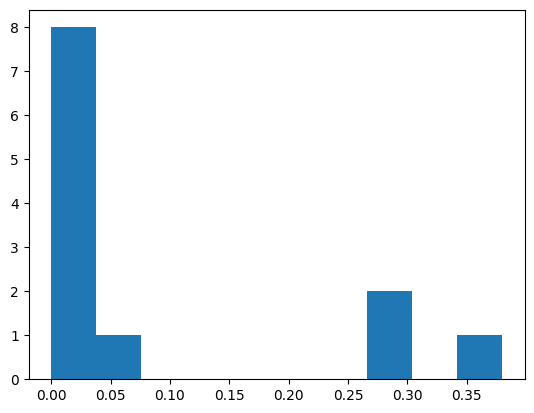

In [24]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

dist = F.softmax(scores, dim=0).detach().cpu().numpy()
plt.hist(dist)

dist.tolist()

In [20]:
top_indices

[6, 4, 10, 2, 0]